# Temperature dependent elastic constants

## Background

$$C_{ijkl} = \frac{1}{V} \frac{\partial^2 U}{\partial \varepsilon_{ij}\partial \varepsilon_{kl}}$$

$$U(T) = \frac{V}{2}C_{ijkl}(T)\varepsilon_{ij}\varepsilon_{kl}$$

$$\sigma_{ij} = C_{ijkl}{\varepsilon_{kl}}$$

### How to get $U$ or $\sigma$

- MD
- Quasi-Harmonic

## Tasks

- Get $a_0$ from potential
- Lattice parameter (as a function of T)
  - MD
    - NVT
    - NPT
  - QH
- Calculate $U$ or $\sigma$ for various $\varepsilon$
  - MD: Equilibriate and average with LAMMPS
  - QH: Get strains from Yuriy's tool and run phonopy
- Fit

## Teams

- MD: Erik, Han, (Raynol), Prabhath, Jan
- QH: Raynol, (Sam), Bharathi, Ahmed, Haitham
- Fit & Yuriy: Sam
- Literature

# Implementation

* https://atomistics.readthedocs.io/en/latest/bulk_modulus_with_gpaw.html#elastic-matrix
* https://github.com/pyiron/atomistics/blob/main/tests/test_elastic_lammpslib_functional.py
* https://github.com/pyiron/pyiron_workflow_atomistics/blob/interstitials/pyiron_workflow_atomistics/dataclass_storage.py
* https://github.com/ligerzero-ai/pyiron_workflow_lammps/blob/main/pyiron_workflow_lammps/engine.py#L21

## Imports

In [1]:
from ase.build import bulk
from ase.atoms import Atoms

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import annotations

from atomistics.workflows.elastic.workflow import (
    # analyse_structures_helper,
    # generate_structures_helper,

    get_tasks_for_elastic_matrix,
    analyse_results_for_elastic_matrix
)

from atomistics.calculators import evaluate_with_lammpslib, get_potential_by_name
from atomistics.calculators.lammps.libcalculator import calc_static_with_lammpslib
from atomistics.calculators import calc_molecular_dynamics_npt_with_lammpslib
from atomistics.calculators import calc_molecular_dynamics_nvt_with_lammpslib

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/__init__.py:41: UserWarning: calc_molecular_dynamics_phonons_with_lammpslib() is not available as the import of the module named 'dynaphopy' failed.
  raise_warning(module_list=lammps_phonon_functions, import_error=e)
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/__init__.py:94: UserWarning: calc_molecular_dynamics_phonons_with_lammpslib() is not available as the import of the module named 'dynaphopy' failed.
  raise_warning(module_list=lammps_phonon_functions, import_error=e)


## Create bulk sample with a guessed lattice constant

In [3]:
unit_cell = bulk('Cu', 'fcc', a=3.6514, cubic=True)
len(unit_cell)

4

In [4]:
repeated_unit_cell = unit_cell.repeat(5)
len(repeated_unit_cell)

500

In [5]:
potential_name_str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"

In [6]:
potential_df = get_potential_by_name(
    potential_name=potential_name_str
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


## 0K Relaxed Structure

In [7]:
def get_relaxed_structure_at_0K(structure: Atoms, potential: str, lmp_optimizer_kwargs : dict = None) -> Atoms:
    
    df_pot_selected = get_potential_by_name(
        potential_name=potential
        )
    
    result_dict = evaluate_with_lammpslib(
        task_dict={"optimize_positions_and_volume": structure},
        potential_dataframe=df_pot_selected,
        lmp_optimizer_kwargs=lmp_optimizer_kwargs
        )
    
    structure_relaxed = result_dict['structure_with_optimized_positions_and_volume']

    return structure_relaxed

In [8]:
lmp_optimizer_kwargs={
    'min_style':'cg',
    'ionic_force_tolerance':1e-8,
    'pressure':np.zeros(6) # add anisotropy
    }

In [9]:
relaxed_unit_cell = get_relaxed_structure_at_0K(
    unit_cell, 
    potential_name_str, 
    lmp_optimizer_kwargs
    )

relaxed_unit_cell

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: cmti001
--------------------------------------------------------------------------


Atoms(symbols='Cu4', pbc=True, cell=[3.6150000810785805, 3.6150000810785805, 3.6150000810785805])

## 0K Lattice Constant

In [10]:
def get_minimum_lattice_constant(structure: Atoms, potential: str, lmp_optimizer_kwargs : dict = None) -> float:

    structure_relaxed = get_relaxed_structure_at_0K(
        structure=structure, 
        potential=potential,
        lmp_optimizer_kwargs=lmp_optimizer_kwargs
        )
    
    a_0 = structure_relaxed.get_volume()**(1/3) #Angstrom

    return a_0

In [11]:
a_0 = get_minimum_lattice_constant(
    structure=unit_cell, 
    potential=potential_name_str,
    lmp_optimizer_kwargs=lmp_optimizer_kwargs)

a_0

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


3.61500008107858

## Reference function to fit elastic constants (Jan + Yury)'s

Requires only `relaxed_unit_cell` and `potential_name_str` from previous cells

In [12]:
def fit_elastic_constants(structure: Atoms, potential: str, strains, stresses=None, energies=None):

    task_dict, sym_dict = get_tasks_for_elastic_matrix(
        structure=structure,
        eps_range=0.005,
        num_of_point=5,
        zero_strain_job_name="s_e_0",
        sqrt_eta=True
        )

    potential_df = get_potential_by_name(
        potential_name=potential
        )

    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=potential_df,
        )
    
    elastic_dict, sym_dict = analyse_results_for_elastic_matrix(
        output_dict=result_dict,
        sym_dict=sym_dict,
        fit_order=2,
        zero_strain_job_name="s_e_0",
        )

    return elastic_dict

In [13]:
# relaxed_structure = get_relaxed_structure_at_0K(unit_cell, potential_name_str)
elastic_dict = fit_elastic_constants(
    structure=relaxed_unit_cell,
    potential=potential_name_str,
    strains=None
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/workflows/elastic/symmetry.py:32: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  SGN = dataset["number"]
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [14]:
elastic_dict['elastic_matrix']

array([[169.74837327, 123.55258251, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 169.74837327, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 123.55258251, 169.74837327,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  76.24914297,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         76.24914297,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  76.24914297]])

In [15]:
elastic_constants_list_reference = [
    elastic_dict['elastic_matrix'][0,0], 
    elastic_dict['elastic_matrix'][0,1], 
    elastic_dict['elastic_matrix'][3,3]
    ]

elastic_constants_list_reference

[169.74837326961014, 123.55258250676765, 76.24914297264033]

## Finite Temperature equlibiration
* First run NPT to relax volume
* Then equilibriate the cell by running NVT

In [16]:
def equilibriate_structure_at_finite_temperature(
        structure : Atoms, potential : str, 
        temperature : float = 500, seed : int = 4928459, cell_scale_value : int = 5
        ) -> Atoms:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
        )
    
    structure_repeated = structure.repeat(cell_scale_value)

    npt_dict = calc_molecular_dynamics_npt_with_lammpslib(
        structure=structure_repeated,
        potential_dataframe=df_pot_selected,
        Tstart=temperature,
        Tstop=temperature,
        run=10000,
        thermo=100,
        seed=seed
        )
    
    npt_lattice_constant = (np.mean(npt_dict['volume'][20:]/len(structure_repeated))*len(structure))**(1/3)
    
    # structure_repeated_npt = bulk('Cu', a=npt_lattice_constant, cubic=True).repeat(5)

    # FIXME: Make it for a generic element - something might be wrong here. Need to check error propagation
    structure_repeated_npt = structure.copy()
    structure_repeated_npt.set_cell(
        [[npt_lattice_constant,0,0], 
         [0,npt_lattice_constant,0], 
         [0,0,npt_lattice_constant]],
        scale_atoms = True
        )
    structure_repeated_npt = structure_repeated_npt.repeat(cell_scale_value)

    nvt_dict = calc_molecular_dynamics_nvt_with_lammpslib(
        structure=structure_repeated_npt,
        potential_dataframe=df_pot_selected,
        Tstart=temperature,
        Tstop=temperature,
        run=10000,
        thermo=100,
        seed=seed
        )    
    structure_repeated_nvt = structure_repeated_npt.copy()
    structure_repeated_nvt.set_cell(
        nvt_dict['cell'][-1]
        )
    structure_repeated_nvt.set_positions(
        nvt_dict['positions'][-1]
        )
    structure_repeated_nvt.set_velocities(
        nvt_dict['velocities'][-1]
        )

    return structure_repeated_nvt

### Run for different sizes

In [27]:
repeated_unit_cell_nvt_300_r5 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=300, 
    seed=1234,
    cell_scale_value=5
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [28]:
repeated_unit_cell_nvt_300_r6 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=300, 
    seed=1234,
    cell_scale_value=6
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [29]:
repeated_unit_cell_nvt_300_r7 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=300, 
    seed=1234,
    cell_scale_value=7
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [33]:
len(repeated_unit_cell_nvt_300_r6)

864

### Run for different temps

In [43]:
repeated_unit_cell_nvt_300 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=300, 
    seed=4928459
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [ ]:
# input should be a unit cell and the output is a repeated cell

repeated_unit_cell_nvt_300 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=300, 
    seed=4928459
    )
repeated_unit_cell_nvt_500 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=500, 
    seed=4928459
    )
repeated_unit_cell_nvt_800 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell,
    potential=potential_name_str, 
    temperature=800, 
    seed=4928459
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [18]:
repeated_unit_cell_nvt_300, repeated_unit_cell_nvt_500, repeated_unit_cell_nvt_800

(Atoms(symbols='Cu500', pbc=True, cell=[18.159633978016213, 18.159633978016213, 18.159633978016213], momenta=...),
 Atoms(symbols='Cu500', pbc=True, cell=[18.22042115296756, 18.22042115296756, 18.22042115296756], momenta=...),
 Atoms(symbols='Cu500', pbc=True, cell=[18.32144627231945, 18.32144627231945, 18.32144627231945], momenta=...))

### Re-run for different seeds to observe the change

In [44]:
repeated_unit_cell_nvt_300_1 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=300, 
    seed=1234
    )
repeated_unit_cell_nvt_300_2 = equilibriate_structure_at_finite_temperature(
    structure=relaxed_unit_cell, 
    potential=potential_name_str, 
    temperature=300, 
    seed=9876
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [20]:
repeated_unit_cell_nvt_300_1 == repeated_unit_cell_nvt_300

False

In [21]:
repeated_unit_cell_nvt_300_2 == repeated_unit_cell_nvt_300_1

False

In [22]:
repeated_unit_cell_nvt_300_2 == repeated_unit_cell_nvt_300

False

## Temperature-dependent Elastic Constants

In [20]:
def get_strain_tensor_cubic(structure : Atoms, strain : float = 0.005):

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    return deformation_gradient_dict

In [21]:
def get_elastic_constants_from_stress_tensor(tensor_dict : dict, strain : float) -> list[float]:

    elastic_constants_list = []

    for constant_str, diff in tensor_dict.items():
        if constant_str == 'C11':
            constant = diff[0, 0] / strain
            elastic_constants_list.append(abs(constant))

        elif constant_str == 'C12':
            sigma33 = diff[2, 2]
            constant = (sigma33/ strain) / 2
            elastic_constants_list.append(abs(constant))

        elif constant_str == 'C44':
            sigma23 = diff[2, 1]
            constant = sigma23 / (2 * strain)
            elastic_constants_list.append(abs(constant))

    return elastic_constants_list

In [22]:
def get_stress_tensor_at_0K(
        structure : Atoms,
        structure_strained : Atoms, 
        potential_dataframe : pd.DataFrame
        ):
    
    relaxed_dict = calc_static_with_lammpslib(
        structure=structure, 
        potential_dataframe=potential_dataframe
        )
    strained_dict = calc_static_with_lammpslib(
        structure=structure_strained,
        potential_dataframe=potential_dataframe
        )

    stress_diff = strained_dict['stress'] - relaxed_dict['stress']

    return stress_diff, relaxed_dict, strained_dict

In [23]:
def get_stress_tensor_at_finite_temperature(
        structure : Atoms, structure_strained : Atoms, potential_dataframe : pd.DataFrame,
        temperature : float, seed : int, thermo : int
        ):
        
        # now we can use disable_initial_velocity=True
        relaxed_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=10000,
            thermo=thermo,
            seed=seed
            )
        strained_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure_strained, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=10000,
            thermo=thermo,
            seed=seed
            )

        stress_diff = -np.mean(strained_dict['pressure'][20:] - relaxed_dict['pressure'][20:], axis=0)

        return stress_diff, relaxed_dict, strained_dict

In [24]:
def get_stress_tensor_at_specific_temperature(
        structure : Atoms, potential_dataframe : pd.DataFrame, 
        deformation_gradient : np.array, temperature : float, 
        seed : int, thermo : int
        ):
    
    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(
        strained_cell, 
        scale_atoms=True
        )

    if temperature == 0:
        stress_diff, relaxed_dict, strained_dict = get_stress_tensor_at_0K(
            structure=structure,
            structure_strained=structure_strained,
            potential_dataframe=potential_dataframe
            )
    else:
        stress_diff, relaxed_dict, strained_dict = get_stress_tensor_at_finite_temperature(
            structure=structure,
            structure_strained=structure_strained,
            potential_dataframe=potential_dataframe,
            temperature=temperature,
            seed=seed,
            thermo=thermo
            )
    
    return stress_diff, relaxed_dict, strained_dict

In [25]:
def calculate_elastic_constants_at_specific_temperature(
        structure : Atoms, potential_name : str, temperature : float = 0, 
        strain : float = 0.005, seed : int = 4928459, thermo : int = 100
        ):

    df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

    deformation_gradient_dict = get_strain_tensor_cubic(
        structure=structure, 
        strain=strain
        )
    
    tensor_dict = {}
    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        diff, relaxed_dict, strained_dict = get_stress_tensor_at_specific_temperature(
            structure=structure, 
            potential_dataframe=df_pot_selected,
            deformation_gradient=deformation_gradient,
            temperature=temperature,
            seed=seed,
            thermo=thermo
            )
        
        tensor_dict[constant_str] = diff
        tensor_dict[f'relaxed_dict_{constant_str}'] = relaxed_dict
        tensor_dict[f'strained_dict_{constant_str}'] = strained_dict
    
    elastic_constants_list = get_elastic_constants_from_stress_tensor(
        tensor_dict=tensor_dict, 
        strain=strain
        )

    return elastic_constants_list, tensor_dict

### 0K Elastic Constants

In [29]:
elastic_constants_list_0, tensor_dict_0 = calculate_elastic_constants_at_specific_temperature(
    structure=relaxed_unit_cell, 
    potential_name=potential_name_str,
    strain=0.005,
    seed=4928459,
    thermo=100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [30]:
# verified to be the same as the result when the 0K code was independent
elastic_constants_list_0

[1692164.6750272135, 1214497.7228949314, 762691.2007684121]

### Finite temperature Elastic Constants

#### Run for different sizes

In [30]:
elastic_constants_list_300_r5, tensor_dict_300_r5 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_300_r5, 
    potential_name=potential_name_str,
    temperature=300,
    strain=0.005,
    seed=1234,
    thermo=100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [31]:
elastic_constants_list_300_r6, tensor_dict_300_r6 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_300_r6, 
    potential_name=potential_name_str,
    temperature=300,
    strain=0.005,
    seed=1234,
    thermo=100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [32]:
elastic_constants_list_300_r7, tensor_dict_300_r7 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_300_r7, 
    potential_name=potential_name_str,
    temperature=300,
    strain=0.005,
    seed=1234,
    thermo=100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [36]:
np.array(elastic_constants_list_300_r5)/10**4, np.array(elastic_constants_list_300_r6)/10**4, np.array(elastic_constants_list_300_r7)/10**4

(array([157.91269612, 119.76151814,  72.00782814]),
 array([163.15467566, 120.196032  ,  70.42444026]),
 array([161.97714712, 116.00823097,  73.06226292]))

In [37]:
len(repeated_unit_cell_nvt_300_r7)

1372

141.7340813120839


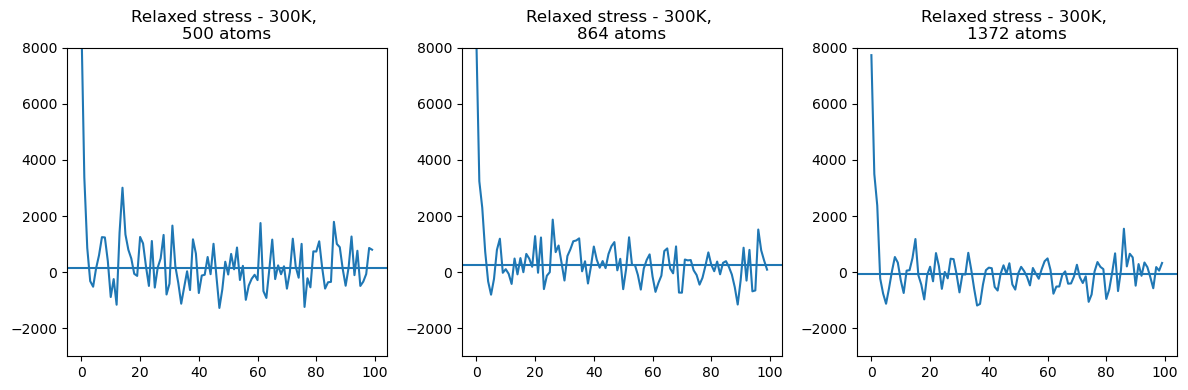

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.set_title(f'Relaxed stress - 300K, \n{len(repeated_unit_cell_nvt_300_r5)} atoms')
ax1.plot(tensor_dict_300_r5['relaxed_dict_C11']['pressure'][:,0,0])

mean_run_r5 = np.mean(tensor_dict_300_r5['relaxed_dict_C11']['pressure'][20:,0,0], axis = 0)
ax1.axhline(mean_run_r5)
print(mean_run_r5)
ax1.set_ylim([-3000, 8000])

ax2.set_title(f'Relaxed stress - 300K, \n{len(repeated_unit_cell_nvt_300_r6)} atoms')
ax2.plot(tensor_dict_300_r6['relaxed_dict_C11']['pressure'][:,0,0])

mean_run_r6 = np.mean(tensor_dict_300_r6['relaxed_dict_C11']['pressure'][20:,0,0], axis = 0)
ax2.axhline(mean_run_r6)
mean_run_r6
ax2.set_ylim([-3000, 8000])


ax3.set_title(f'Relaxed stress - 300K, \n{len(repeated_unit_cell_nvt_300_r7)} atoms')
ax3.plot(tensor_dict_300_r7['relaxed_dict_C11']['pressure'][:,0,0])

mean_run_r7 = np.mean(tensor_dict_300_r7['relaxed_dict_C11']['pressure'][20:,0,0], axis = 0)
ax3.axhline(mean_run_r7)
mean_run_r7
ax3.set_ylim([-3000, 8000])


plt.tight_layout()

#### Run 0

In [45]:
elastic_constants_list_300, tensor_dict_300 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_300, 
    potential_name=potential_name_str,
    temperature=300,
    strain=0.005,
    seed=4928459,
    thermo=100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [ ]:
elastic_constants_list_500, tensor_dict_500 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_500, 
    potential_name=potential_name_str,
    temperature=500,
    strain=0.005,
    seed=4928459,
    thermo=100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [33]:
elastic_constants_list_800, tensor_dict_800 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_800, 
    potential_name=potential_name_str,
    temperature=800,
    strain=0.005,
    seed=4928459,
    thermo=100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [34]:
# verified to be the same as the result when the finite temp code was independent
elastic_constants_list_300, elastic_constants_list_500, elastic_constants_list_800

([1708047.1698537243, 1200998.912591118, 736383.9337147959],
 [1441135.5664244464, 1122482.3368255557, 673224.0241416948],
 [1406660.9522165915, 1059775.5001629365, 579655.0862127924])

#### Run 1 - different seed

In [46]:
elastic_constants_list_300_1, tensor_dict_300_1 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_300_1, 
    potential_name=potential_name_str,
    temperature=300,
    strain=0.005,
    seed=1234,
    thermo= 100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


#### Run 2 - different seed

In [47]:
elastic_constants_list_300_2, tensor_dict_300_2 = calculate_elastic_constants_at_specific_temperature(
    structure=repeated_unit_cell_nvt_300_2, 
    potential_name=potential_name_str,
    temperature=300,
    strain=0.005,
    seed=9876,
    thermo= 100
    )

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [48]:
elastic_constants_list_300

[1708047.1698537243, 1200998.912591118, 736383.9337147959]

In [49]:
elastic_constants_list_300_1

[1579126.9611630437, 1197615.1814067382, 720078.2814069496]

In [50]:
elastic_constants_list_300_2

[1581674.8486534993, 1198248.1584729487, 703985.7860454394]

#### Diagnostics

(-2500.0, 6000.0)

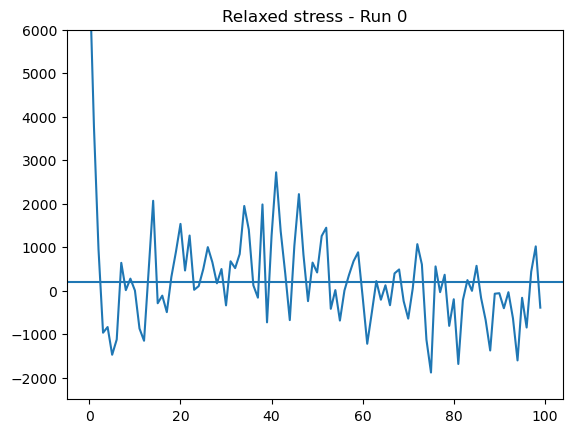

In [55]:
plt.title('Relaxed stress - Run 0')
plt.plot(tensor_dict_300['relaxed_dict_C11']['pressure'][:,0,0])

mean_run_0 = np.mean(tensor_dict_300['relaxed_dict_C11']['pressure'][20:,0,0], axis = 0)
plt.axhline(mean_run_0)
mean_run_0
plt.ylim([-2500, 6000])

(-2500.0, 6000.0)

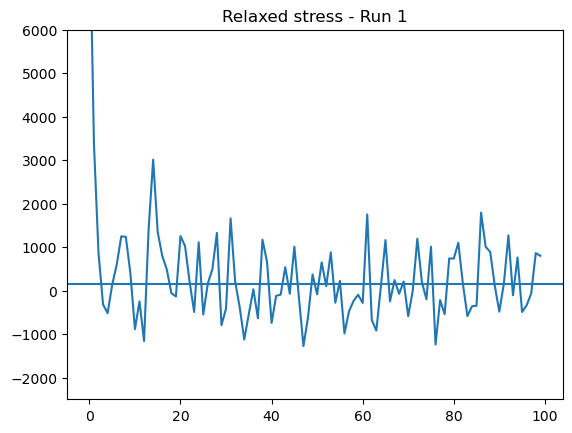

In [56]:
plt.title('Relaxed stress - Run 1')
plt.plot(tensor_dict_300_1['relaxed_dict_C11']['pressure'][:,0,0])

mean_run_1 = np.mean(tensor_dict_300_1['relaxed_dict_C11']['pressure'][20:,0,0], axis = 0)
plt.axhline(mean_run_1)
mean_run_1
plt.ylim([-2500, 6000])


Text(0.5, 1.0, 'Strained stress - Run 1')

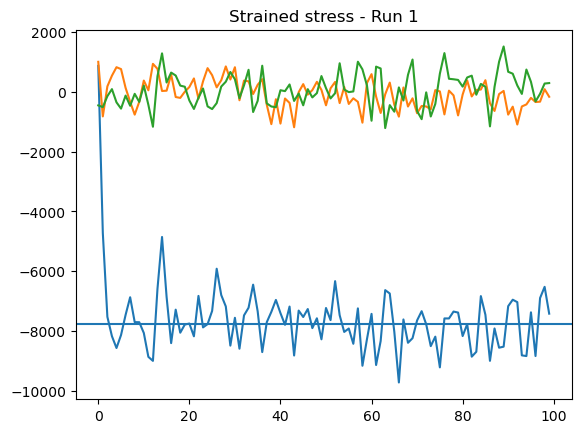

In [53]:
plt.plot(tensor_dict_300_1['strained_dict_C11']['pressure'][:,:,0])
plt.axhline(np.mean(tensor_dict_300_1['strained_dict_C11']['pressure'][20:,0,0], axis = 0))
plt.title('Strained stress - Run 1')